<a href="https://colab.research.google.com/github/haggishm/Stock_Prediction/blob/master/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary packages
#$ pip install pandas-datareader
#$ pip install yahoo-finance
from pandas_datareader import data as wb
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import csv
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD



In [0]:
#Use this option for web download if Yahoo will let you.
start = datetime.datetime(2010, 6, 29)
end = datetime.datetime(2019, 8, 30)
df = wb.DataReader("TSLA", 'yahoo', start, end)

In [77]:
#load csv from dropbox

!wget -O tesla.csv https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1
  
df = pd.read_csv('tesla.csv')

--2019-09-06 09:33:48--  https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/na2vurooejpew59/TSLA.csv [following]
--2019-09-06 09:33:48--  https://www.dropbox.com/s/dl/na2vurooejpew59/TSLA.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0bb15306aabac468c5393c974e.dl.dropboxusercontent.com/cd/0/get/AoDA_snvgH9L1nLzhxVsw3KBsW_JB-7kL4GF5mcZOouEYqpvAw1B7gjnu95ZofeYUt1iqH8Pk0ife9BhSuikq2cQnJX6t4_9LqnajxL9oUhrsE3Vh4ffuyOEA32AKIrZhW0/file?dl=1# [following]
--2019-09-06 09:33:48--  https://uc0bb15306aabac468c5393c974e.dl.dropboxusercontent.com/cd/0/get/AoDA_snvgH9L1nLzhxVsw3KBsW_JB-7kL4GF5mcZOouEYqpvAw1B7gjnu95ZofeYUt1iqH8Pk0ife9BhSuikq2cQnJX6t4_9LqnajxL9oUhrsE3Vh4ffuyOEA32A

In [80]:
#Set date as index column
df.set_index('Date', inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-26,213.600006,215.020004,211.539993,215.000000,215.000000,5051900
2019-08-27,215.740005,218.800003,212.029999,214.080002,214.080002,5416200
2019-08-28,213.690002,217.250000,212.309998,215.589996,215.589996,3225500
2019-08-29,219.000000,223.399994,218.000000,221.710007,221.710007,5179500
2019-08-30,229.149994,232.440002,224.210007,225.610001,225.610001,9320600


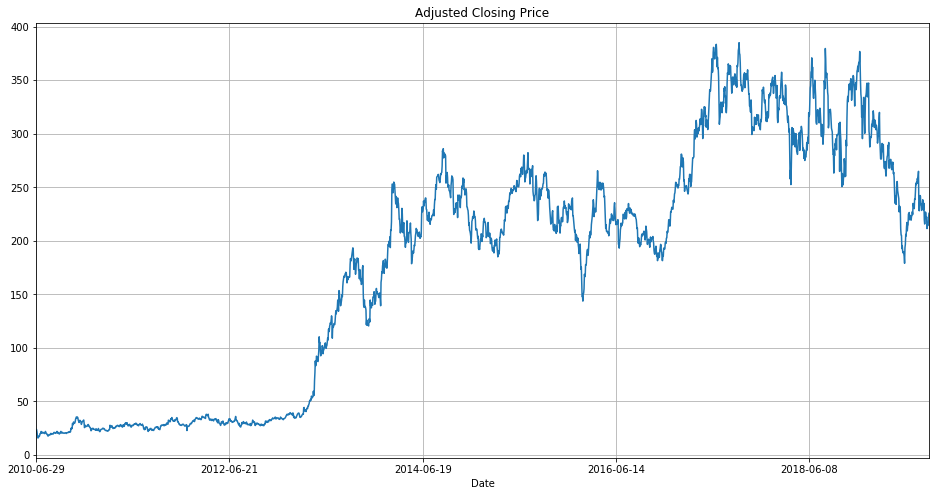

In [24]:
#Plot Adjusted close
df['Adj Close'].plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day


In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# Model #1 Ridge Regression

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)



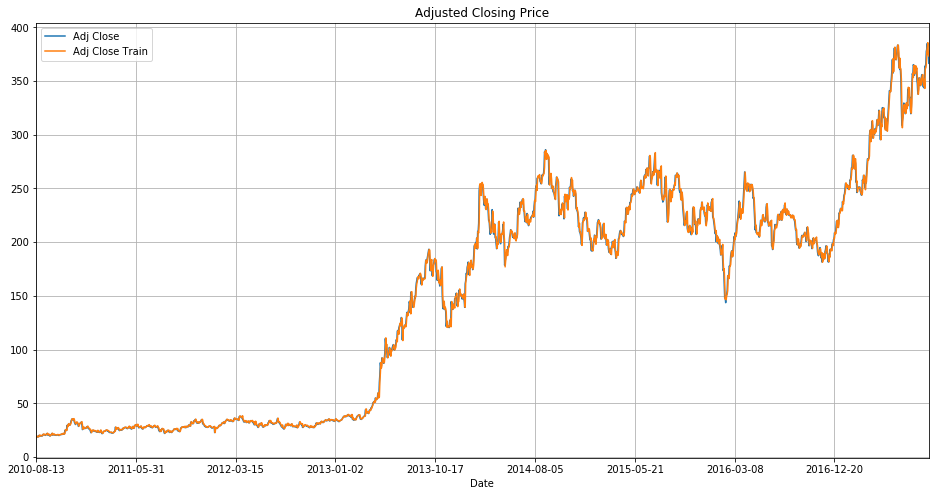

In [30]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

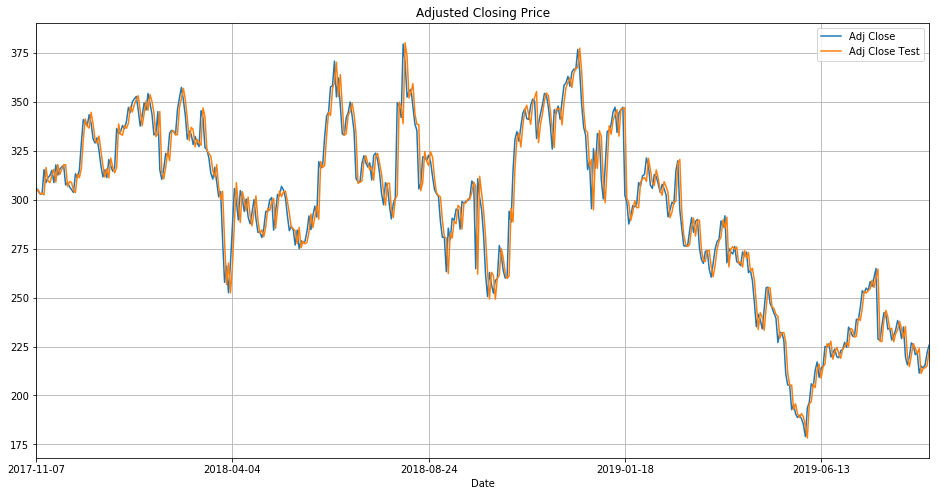

In [31]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Model #2 Recurrent neural networks

In [32]:
# Model #2 - Using Recurrent neural networks
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()



W0906 07:53:04.306375 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 07:53:04.367592 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 07:53:04.374896 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [33]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0906 07:53:13.896385 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [34]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0906 07:53:22.925705 139647251195776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0906 07:53:24.238390 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 07:53:24.298925 139647251195776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1822 samples, validate on 456 samples
Epoch 1/250
1822/1822 [==============================] - 6s 3ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - val_loss: 0.1429 - val_mean_absolute_error: 0.4878
Epoch 2/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - val_loss: 0.1429 - val_mean_absolute_error: 0.4878
Epoch 3/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - val_loss: 0.1429 - val_mean_absolute_error: 0.4878
Epoch 4/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - val_loss: 0.1429 - val_mean_absolute_error: 0.4878
Epoch 5/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - val_loss: 0.1429 - val_mean_absolute_error: 0.4878
Epoch 6/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.4857 - va

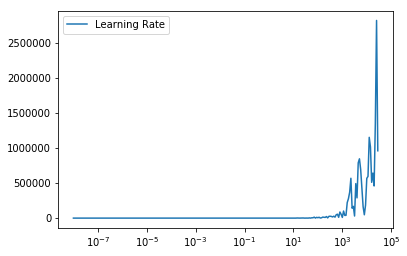

In [35]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

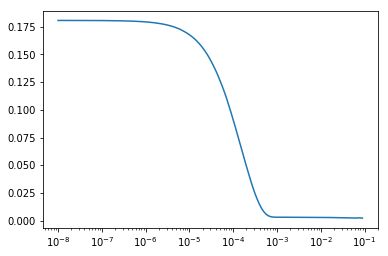

In [36]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [37]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1822 samples, validate on 456 samples
Epoch 1/250
1822/1822 [==============================] - 6s 3ms/step - loss: 0.0733 - mean_absolute_error: 0.3097 - val_loss: 0.0095 - val_mean_absolute_error: 0.1086
Epoch 2/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.1621 - val_loss: 0.0356 - val_mean_absolute_error: 0.2342
Epoch 3/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.0126 - mean_absolute_error: 0.1171 - val_loss: 0.0087 - val_mean_absolute_error: 0.1052
Epoch 4/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.1257
Epoch 5/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.0048 - mean_absolute_error: 0.0702 - val_loss: 0.0080 - val_mean_absolute_error: 0.1017
Epoch 6/250
1822/1822 [==============================] - 4s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0579 - va

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

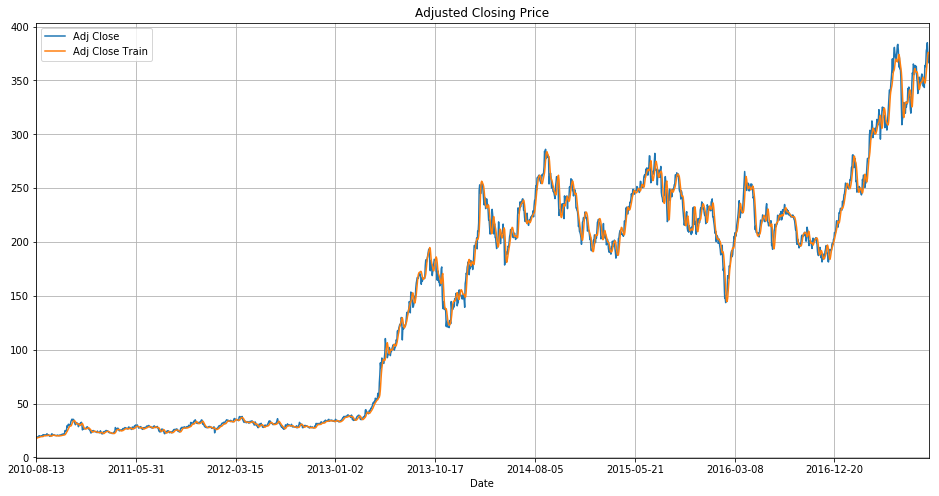

In [40]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

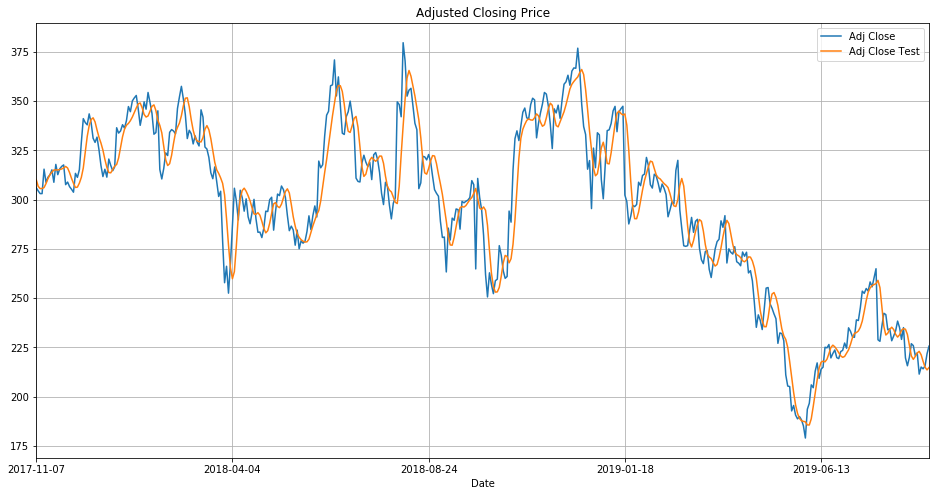

In [41]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)



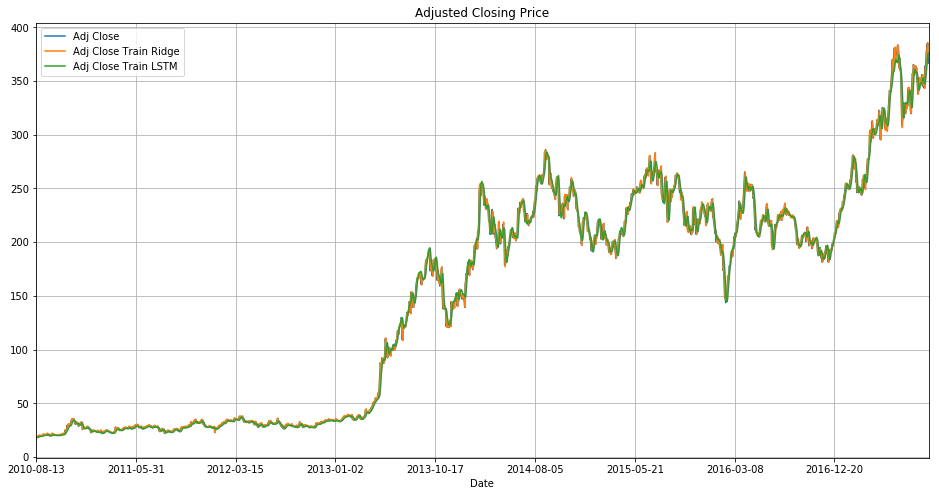

In [44]:


df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
#df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)



,Adj Close,Adj Close Test Ridge,Adj Close Test LSTM
Date,,,
2019-08-26,215.000000,211.239003,221.198349
2019-08-27,214.080002,213.714998,217.874115
2019-08-28,215.589996,214.139527,214.887589
2019-08-29,221.710007,215.128621,213.539322
2019-08-30,225.610001,222.720928,214.730927


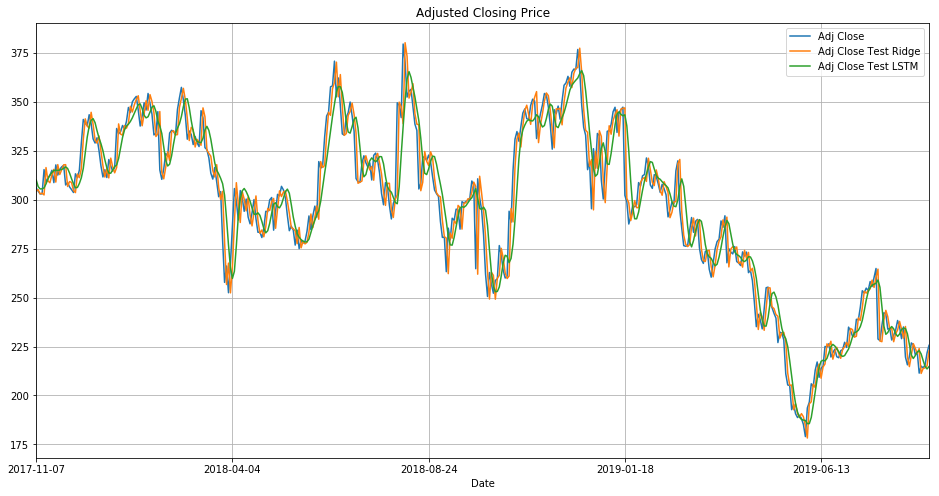

In [74]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
#df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)
df_test.tail()

## Model #3 Linear Regression

In [0]:
# Train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
confidencereg = linear_model.score(X_test, y_test)
#confidencereg

# Infer
y_pred_train_linear = linear_model.predict(X_train)
y_pred_linear = linear_model.predict(X_test)

,Adj Close,Adj Close Train
Date,,
2017-09-15,379.809998,377.380142
2017-09-18,385.000000,380.968022
2017-09-19,375.100006,385.679426
2017-09-20,373.910004,374.463806
2017-09-21,366.480011,373.339600


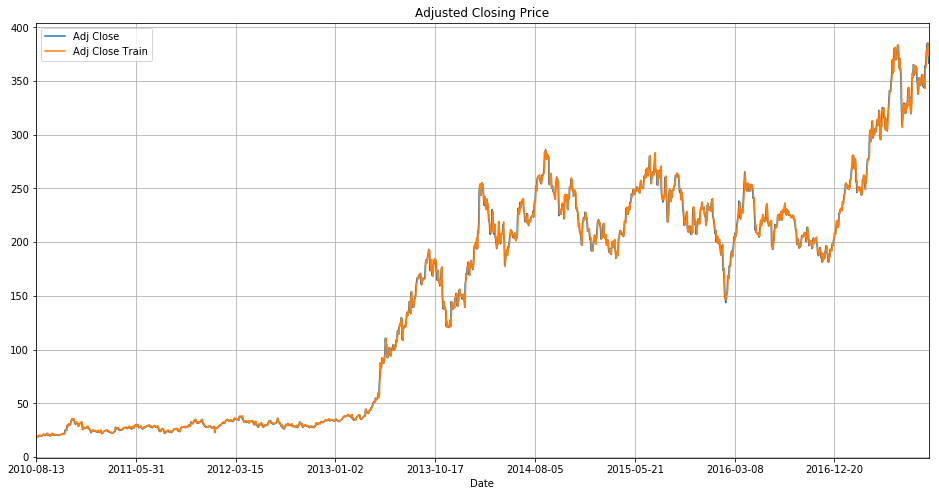

In [71]:
# Plot what it looks like for the training data
df_linear = df.copy()
df_linear.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_linear = df_linear.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_linear['Adj Close Train'] = y_pred_train_linear[:-window_size]
df_linear.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)
df_linear.tail()

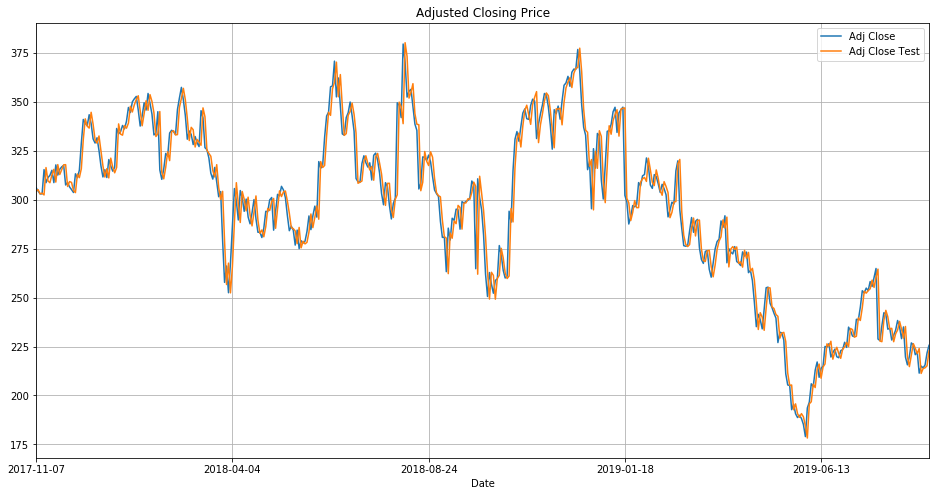

In [72]:
# Same for the test
df_linear = df.copy()
df_linear.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_linear = df_linear.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_linear['Adj Close Test'] = y_pred_linear
df_linear.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Model #4 - Quadratic Regression 2

In [0]:
# Quadratic Regression 2
poly2_model = make_pipeline(PolynomialFeatures(2), Ridge())
poly2_model.fit(X_train, y_train)
confidencepoly2 = poly2_model.score(X_test, y_test)
confidencepoly2


# Infer
y_pred_train_poly2 = poly2_model.predict(X_train)
y_pred_poly2 = poly2_model.predict(X_test)

,Adj Close,Adj Close Train
Date,,
2017-09-15,379.809998,380.458461
2017-09-18,385.000000,383.983316
2017-09-19,375.100006,373.203470
2017-09-20,373.910004,373.781324
2017-09-21,366.480011,366.290261


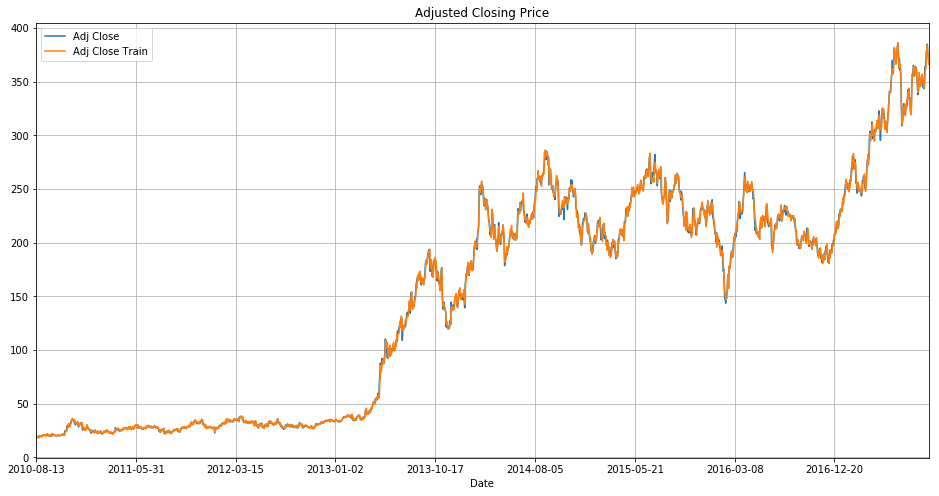

In [61]:
# Plot what it looks like for the training data
df_poly2 = df.copy()
df_poly2.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_poly2 = df_poly2.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_poly2['Adj Close Train'] = y_pred_train_poly2[:-window_size]
df_poly2.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)
df_poly2.tail()

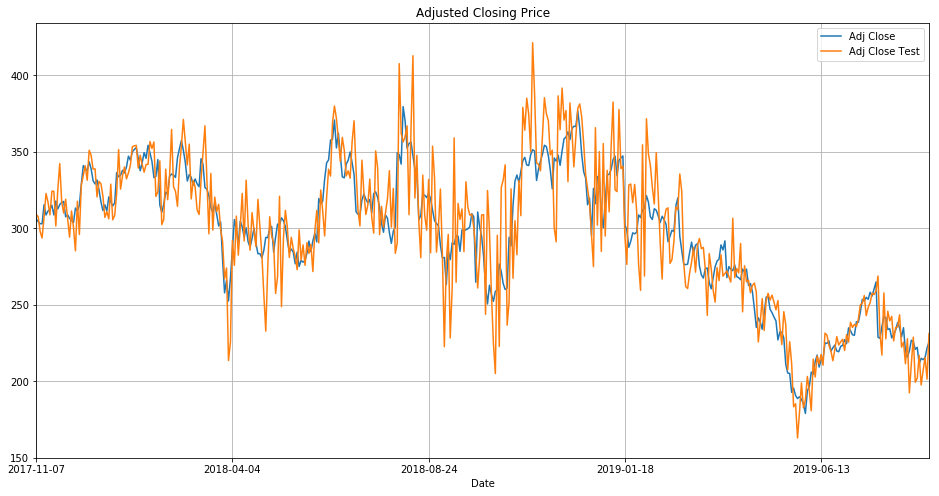

In [65]:
# Same for the test
df_poly2 = df.copy()
df_poly2.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_poly2 = df_poly2.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_poly2['Adj Close Test'] = y_pred_poly2
df_poly2.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Model #5 Gradient Boosting Trees



In [0]:

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)



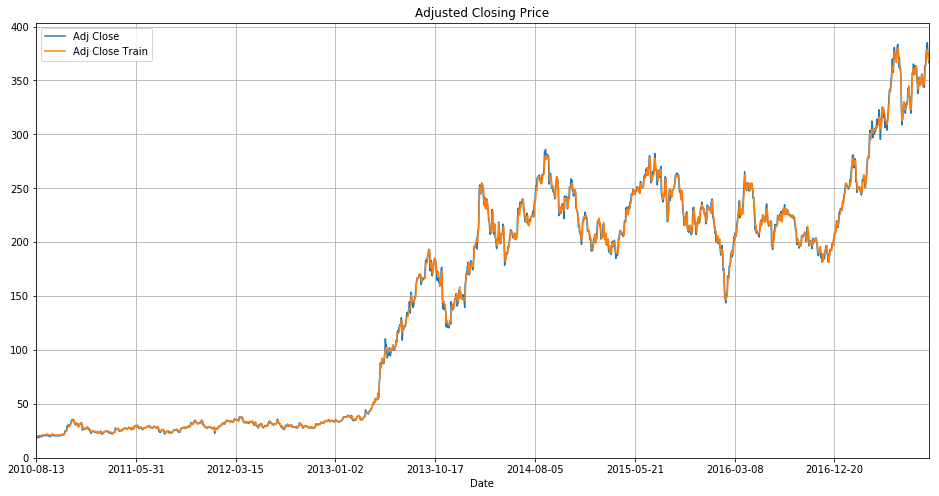

In [63]:


# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)



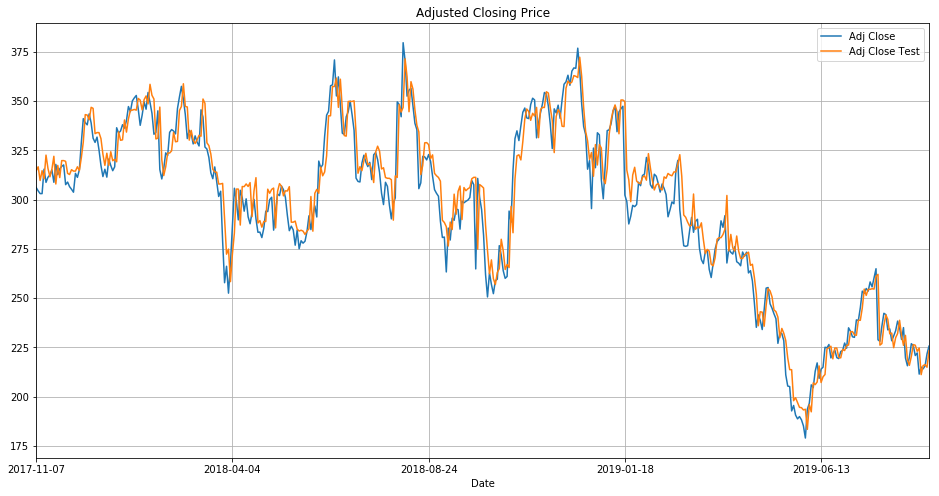

In [64]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)